In [1]:
import pandas as pd
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('fivethirtyeight')
%matplotlib inline
import matplotlib.ticker as ticker


# 0. Load the clean dataset

Created in the notebook
https://github.com/yortos/imessage-analysis/blob/master/imessages-data-extract-and-prep.ipynb

In [ ]:
df_messages = pd.read_csv("./imessages_cleaned.csv")

# convert the dates and timestamps from strings to dates for cleaner plots
df_messages['timestamp'] = df_messages['timestamp'].apply(lambda x: pd.Timestamp(x))
df_messages['date'] = df_messages['timestamp'].apply(lambda x: x.date())

# 1. Number of Messages Per Day

In [3]:
# Helper function to avoid repetition

def get_rolling_avg(daily_count, column_name='received_messages', window_size=7):
    ''' Take a df as an input and returs the rolling average of the column name'''
    daily_count_df = daily_count.reset_index(name=column_name)
    daily_count_df = daily_count_df.sort_values('date')
    daily_count_df.set_index('date', inplace=True)

    daily_count_df['running_avg'] = daily_count_df[column_name].rolling(window=window_size).mean()
    return daily_count_df

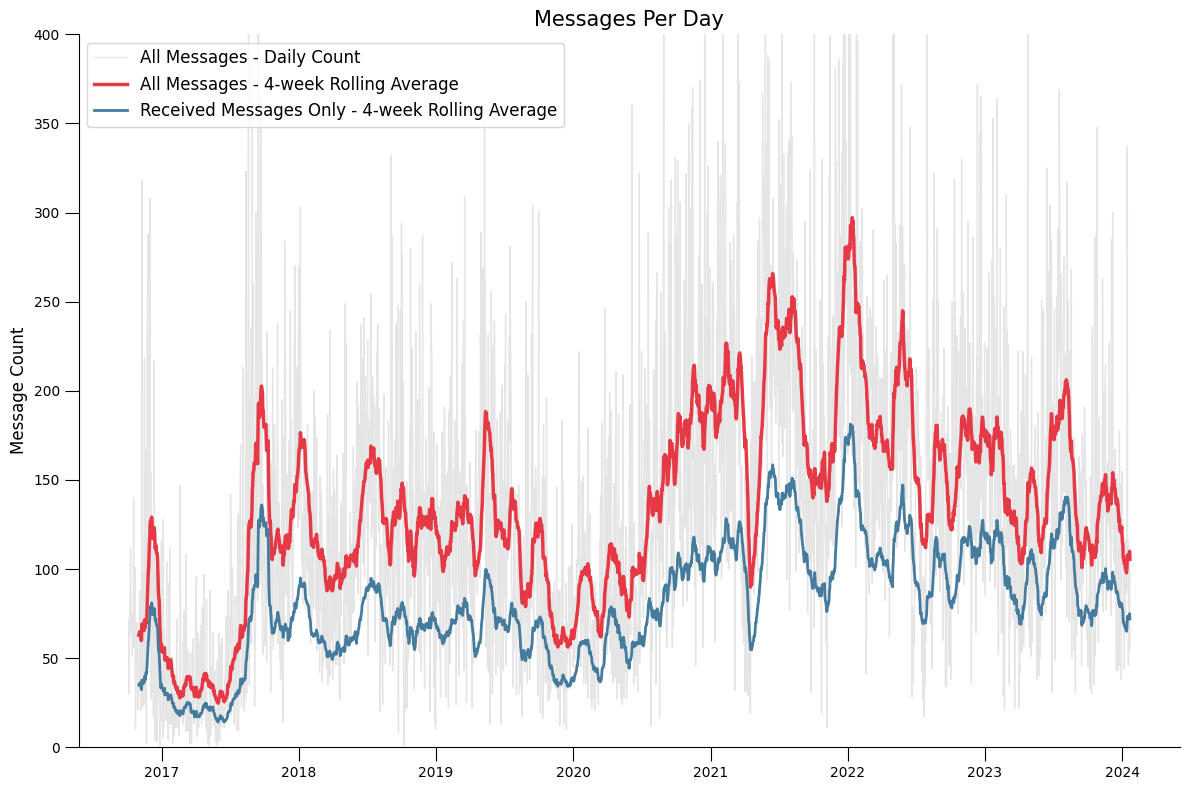

In [4]:
plt.figure(figsize=(12,8))

plt.title("Messages Per Day", fontsize=15)

daily_count = df_messages.groupby('date').size()
daily_count_received = df_messages.loc[df_messages['is_sent']==0].groupby('date').size()

window_size=28

# plot
plt.plot(daily_count, color='grey',lw=1, alpha=0.2, label='All Messages - Daily Count')
plt.plot(get_rolling_avg(daily_count,window_size=window_size)['running_avg'], color='#e63946', linewidth=2.5, label='All Messages - 4-week Rolling Average')
plt.plot(get_rolling_avg(daily_count_received,window_size=window_size)['running_avg'], color='#457b9d', lw=2, label='Received Messages Only - 4-week Rolling Average')

plt.legend(loc='upper left', fontsize='large')
sns.despine()
plt.ylabel('Message Count', fontsize=12)
plt.tick_params(size=10)
plt.ylim((0,400))
plt.tight_layout()

# I created a subfolder to save the plots.
# plt.savefig('../plots/messages_per_day.png', dpi=200)


### Messages per year

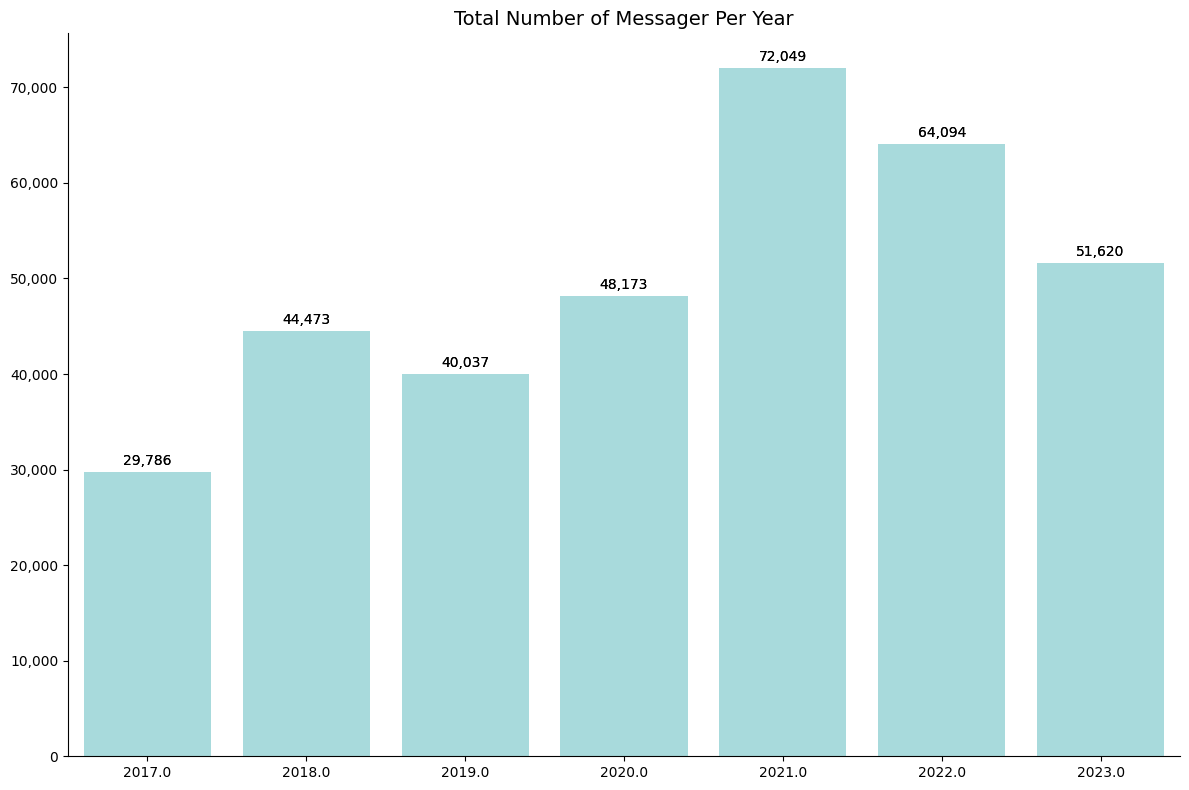

In [12]:
# here I only count the full years from 2017 to 2023. You can modify or remove as it serves you best.
yearly_counts = df_messages.loc[df_messages['year'].apply(lambda x: x>=2017 and x<=2023)].groupby('year').size()

plt.figure(figsize=(12, 8))
bars = plt.bar(range(7), yearly_counts, color='#a8dadc')


bars = yearly_counts.plot(kind='bar', color='skyblue', alpha=0)

plt.xticks(rotation=0)
plt.xlabel('')

# add the values on top of the bars
for bar in bars.patches:
    # The text annotation for each bar
    bars.annotate('{:,}'.format(int(bar.get_height())), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
    
sns.despine()
formatter = ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)
plt.title("Total Number of Messager Per Year", fontsize=14)
plt.tight_layout()


### Ratio of Sent vs Received

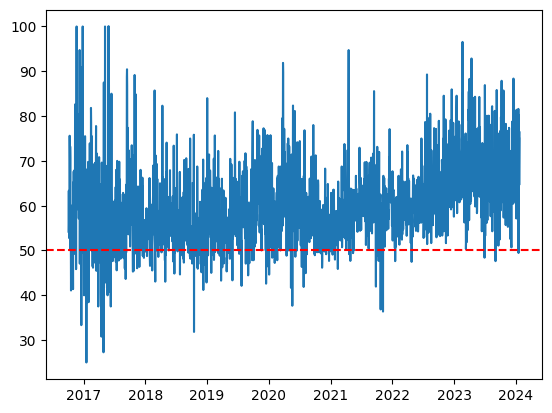

In [13]:
plt.plot(df_messages.loc[df_messages['is_sent']==0].groupby('date').size()/\
         df_messages.groupby('date').size()*100)

plt.axhline(y=50, color='r', ls='dashed')

### For specific person

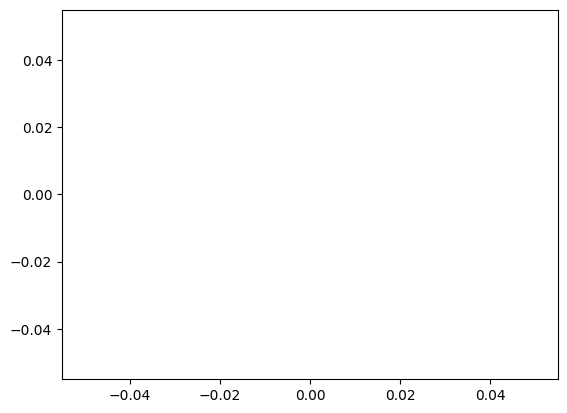

In [14]:
# you can plot the number of messages for any number of specific people over time

contacts = ["+123456789"]
x = df_messages.loc[df_messages['contact_info'].apply(lambda x: x in contacts)].groupby('date').size()

plt.plot(get_rolling_avg(x,window_size=28)['running_avg'])

contacts = ["+1222333455"]
y = df_messages.loc[df_messages['contact_info'].apply(lambda x: x in contacts)].groupby('date').size()

plt.plot(get_rolling_avg(y,window_size=28)['running_avg'])

# 2. Most Texted People

In [15]:
'''
Here I only include direct messages, i.e., group_chat=False
but you edit or remove as it serves you best.
'''

most_texted_people = df_messages.loc[df_messages['is_group_chat']==False].groupby('name').size().sort_values(ascending=False)
most_texted_people.reset_index(name = 'Number of Messages')[:10].style.background_gradient(cmap='Blues')


,name,Number of Messages
0,Katherine Richardson,50682
1,+15183898676,35009
2,Anthi Askalidou,15761
3,+306932384392,10165
4,+13057942891,5240
5,+16518959121,4734
6,+16309159447,4291
7,+15044536827,2750
8,+16469209965,1654
9,ni.karwat@gmail.com,1582


# 3. Texting Directly vs Group Chat

In [9]:
all_messages_per_person = df_messages.loc[df_messages['name'].apply(lambda x: '+' not in str(x))].groupby(['name']).size().reset_index(name='All Messages')
direct_messages_per_person = df_messages.loc[df_messages['is_group_chat']==True].groupby('name').size().reset_index(name='Messages in Group Chats')


merged =  pd.merge(all_messages_per_person, direct_messages_per_person, on='name', how='inner')
merged.sort_values(by='All Messages',ascending=False, inplace=True)
merged['% in Group Chats'] = merged.apply(lambda x: round(x['Messages in Group Chats']/x['All Messages']*100,1), axis=1)
merged[:20][['name', 'All Messages', '% in Group Chats']].style.background_gradient(cmap='Blues').format({'% in Group Chats': "{:.1f}%"})


,name,All Messages,% in Group Chats
1,Katherine Richardson,54891,7.0%
0,Anthi Askalidou,25911,39.1%
4,elmirabaib@gmail.com,9016,99.8%
12,romeosaskalidis2@gmail.com,1123,99.6%
8,marcos.papaleontiou@icloud.com,947,1.2%
7,krichardson.928@gmail.com,629,58.2%
13,romeosaskalidis@gmail.com,557,98.9%
10,mmilkvas@hotmail.com,296,97.6%
15,taisa-16@hotmail.com,239,97.5%
5,gingitwo@aol.com,101,97.0%


# 4 & 5. Average Texts Per Day and Number of Texted Days Per Person

In [17]:
time_periods = pd.DataFrame({ 'cnt_messages' : df_messages.groupby('name').size(),
                              'min_date' : df_messages.groupby('name')['date'].min(),
                              'max_date' : df_messages.groupby('name')['date'].max(),
                              'cnt_message_days' : df_messages.groupby('name')['date'].nunique()}).reset_index()


time_periods['today'] = date.today()
time_periods['num_days_since_first_message_to_last_message'] = time_periods.apply(lambda x: (x['max_date']-x['min_date']).days, axis=1 )
time_periods['num_days_since_first_message'] = time_periods.apply(lambda x: (x['today']-x['min_date']).days, axis=1 )
time_periods.sort_values(by='cnt_messages', ascending=False, inplace=True)

time_periods['avg_messages_per_day'] = time_periods['cnt_messages']/time_periods['num_days_since_first_message']
time_periods['pct_texting_days'] = time_periods['cnt_message_days']/time_periods['num_days_since_first_message']*100

time_periods.head()

,name,cnt_messages,min_date,max_date,cnt_message_days,today,num_days_since_first_message_to_last_message,num_days_since_first_message,avg_messages_per_day,pct_texting_days
628,Katherine Richardson,54891,2017-06-23,2024-01-22,1979,2024-01-22,2404,2404,22.833195,82.321131
157,+15183898676,36270,2017-08-09,2024-01-22,1385,2024-01-22,2357,2357,15.388205,58.761137
627,Anthi Askalidou,25911,2017-02-26,2024-01-22,1570,2024-01-22,2521,2521,10.278064,62.276874
477,+306932384392,16367,2016-10-05,2021-12-13,1391,2024-01-22,1895,2665,6.141463,52.195122
633,elmirabaib@gmail.com,9016,2016-12-05,2024-01-22,1167,2024-01-22,2604,2604,3.462366,44.815668


In [18]:
time_periods[['name','avg_messages_per_day','pct_texting_days','num_days_since_first_message']].head().\
style.background_gradient(cmap='Blues').format({'pct_texting_days': "{:.1f}%",\
                                               'avg_messages_per_day' :"{:.1f}"})



,name,avg_messages_per_day,pct_texting_days,num_days_since_first_message
628,Katherine Richardson,22.8,82.3%,2404
157,+15183898676,15.4,58.8%,2357
627,Anthi Askalidou,10.3,62.3%,2521
477,+306932384392,6.1,52.2%,2665
633,elmirabaib@gmail.com,3.5,44.8%,2604


# 6. Seasonality

## 6a. Day of Week

In [26]:
# run this in case there are some rows with null values for the date
# df_messages.dropna(subset=['date'], inplace=True)

In [27]:
# assign the day of week to a column
# dow is the English word of the day
# dow_number is a numbering starting from 0 being Monday

df_messages['dow'] = df_messages['date'].apply(lambda x: x.strftime("%A"))
df_messages['dow_number'] = df_messages['date'].apply(lambda x: x.weekday())

per_dow = pd.DataFrame({'cnt_received' : df_messages.loc[df_messages['is_sent']==0].groupby('dow_number').size(),\
                        'cnt_sent' : df_messages.loc[df_messages['is_sent']==1].groupby('dow_number').size(),
                        'dow': df_messages.loc[df_messages['is_sent']==0].groupby('dow_number')['dow'].min()})


per_dow['pct_of_total_received'] = per_dow['cnt_received'].apply(lambda x: x/per_dow['cnt_received'].sum()*100)
per_dow['pct_of_total_sent'] = per_dow['cnt_sent'].apply(lambda x: x/per_dow['cnt_sent'].sum()*100)

per_dow

,cnt_received,cnt_sent,dow,pct_of_total_received,pct_of_total_sent
dow_number,,,,,
0,31846,21179,Monday,14.728653,14.758885
1,30316,21281,Tuesday,14.021034,14.829965
2,32286,21731,Wednesday,14.932152,15.143554
3,32070,20956,Thursday,14.832253,14.603484
4,32829,21770,Friday,15.183287,15.170732
5,28614,18354,Saturday,13.233866,12.790244
6,28257,18229,Sunday,13.068755,12.703136


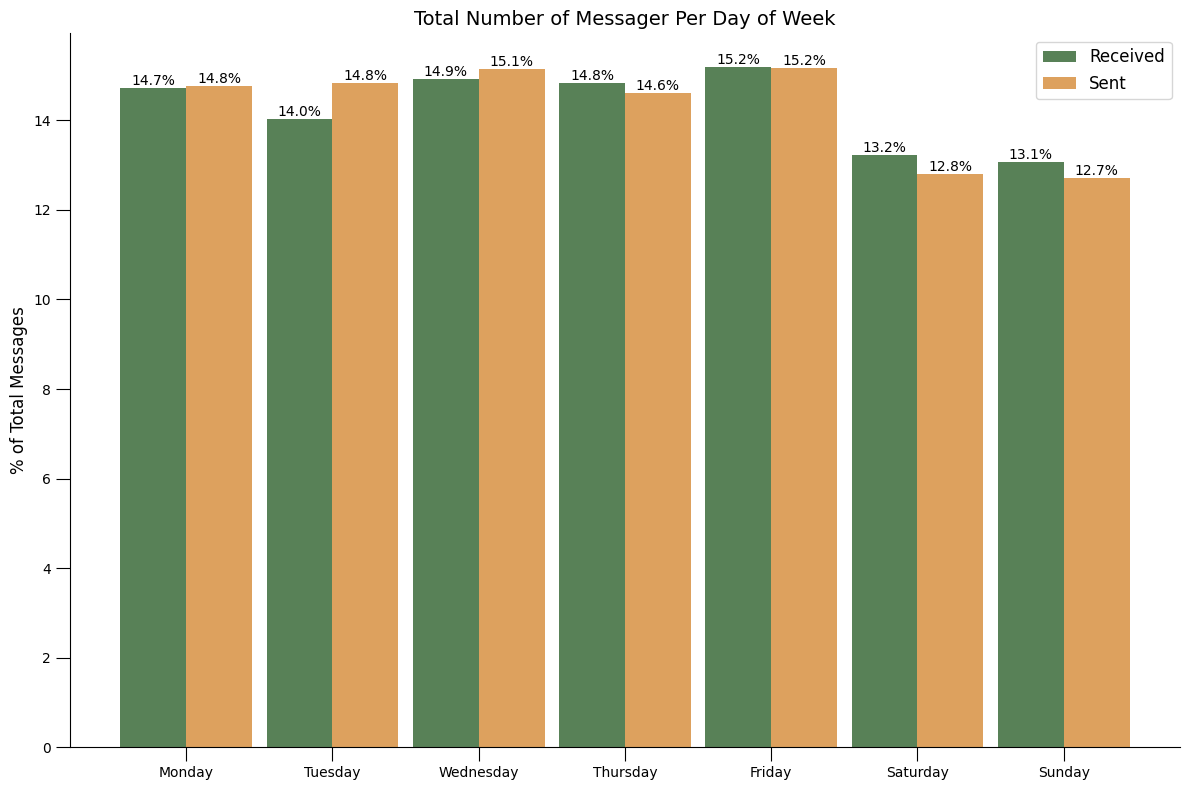

In [28]:
plt.figure(figsize=(12, 8))

# You need to use at most 0.5 so that two bars can fit in one slot.
# I use 0.45 so that there is some space between slots.
width=0.45 
bars_received = plt.bar(range(7), per_dow['pct_of_total_received'], color='#588157', width=width, label='Received')
bars_sent = plt.bar([x+width for x in range(7)], per_dow['pct_of_total_sent'], color='#dda15e', width=width, label='Sent')


plt.xticks([x+width/2 for x in range(7)], per_dow['dow'], rotation=0)

plt.xlabel('')

for bar in bars_received.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, str(round(yval, 1))+'%', va='bottom', ha='center')

for bar in bars_sent.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, str(round(yval, 1))+'%', va='bottom', ha='center')
    
plt.legend(loc='best', fontsize='large')

sns.despine()
# formatter = ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')
# plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel("% of Total Messages", fontsize=12)
plt.tick_params(size=10)
plt.title("Total Number of Messager Per Day of Week", fontsize=14)
plt.tight_layout()


## 6b. Day of the Month - Simplified into three groups

In [29]:
def part_of_month(n):
    if n<11:
        return 0
    elif n<21:
        return 1
    else:
        return 2


df_messages['day_of_month'] = df_messages['date'].apply(lambda x: x.day)
df_messages['part_of_month'] = df_messages['day_of_month'].apply(lambda x: part_of_month(x))


# per day of month - omitting here, for the simpler part of month
# per_dom = pd.DataFrame({'cnt_received' : df_messages.loc[df_messages['is_sent']==0].groupby('day_of_month').size(),
#                        'cnt_sent': df_messages.loc[df_messages['is_sent']==1].groupby('day_of_month').size() }).reset_index()

# per_dom['pct_of_total_received'] = per_dom['cnt_received'].apply(lambda x: x/per_dom['cnt_received'].sum()*100)
# per_dom['pct_of_total_sent'] = per_dom['cnt_sent'].apply(lambda x: x/per_dom['cnt_sent'].sum()*100)


per_dom = pd.DataFrame({'cnt_received' : df_messages.loc[df_messages['is_sent']==0].groupby('part_of_month').size(),
                       'cnt_sent': df_messages.loc[df_messages['is_sent']==1].groupby('part_of_month').size() }).reset_index()

per_dom['pct_of_total_received'] = per_dom['cnt_received'].apply(lambda x: x/per_dom['cnt_received'].sum()*100)
per_dom['pct_of_total_sent'] = per_dom['cnt_sent'].apply(lambda x: x/per_dom['cnt_sent'].sum()*100)


per_dom

,part_of_month,cnt_received,cnt_sent,pct_of_total_received,pct_of_total_sent
0,0,71260,47969,32.957478,33.427875
1,1,71743,46566,33.180864,32.450174
2,2,73215,48965,33.861658,34.121951


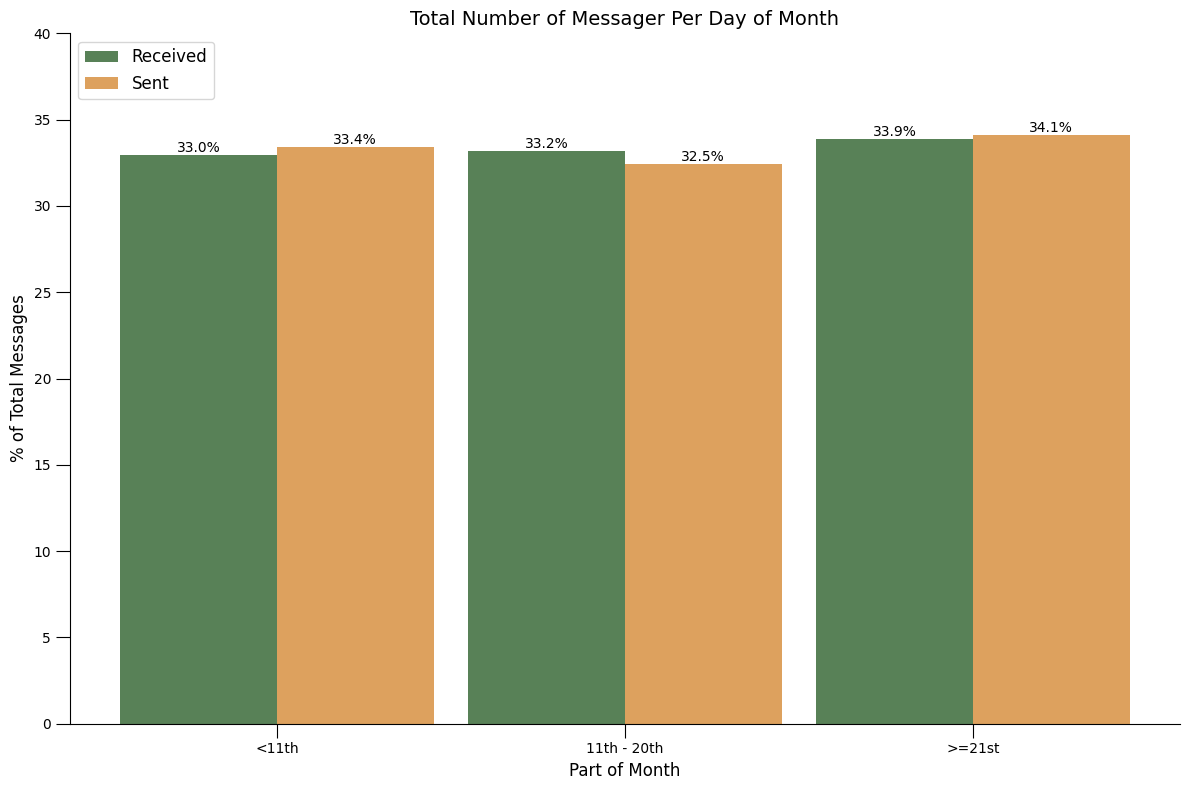

In [31]:
## part of month

plt.figure(figsize=(12, 8))
width=0.45

bars_received = plt.bar(range(3), per_dom['pct_of_total_received'], color='#588157', width=width, label='Received')
bars_sent = plt.bar([x+width for x in range(3)], per_dom['pct_of_total_sent'], color='#dda15e', width=width, label='Sent')


plt.xticks([x +width/2 for x in range(3)], ['<11th', '11th - 20th','>=21st'], rotation=0)

plt.xlabel('')

for bar in bars_received.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, str(round(yval, 1))+'%', va='bottom', ha='center')
    
for bar in bars_sent.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, str(round(yval, 1))+'%', va='bottom', ha='center')

    
sns.despine()
# formatter = ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')
# plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel("% of Total Messages", fontsize=12)
plt.tick_params(size=10)
plt.ylim((0,40))
plt.xlabel('Part of Month', fontsize=12)
plt.legend(loc='upper left', fontsize='large')
plt.title("Total Number of Messager Per Day of Month", fontsize=14)
plt.tight_layout()


## 6c. Month of year

In [32]:
# helped dictionary to translate months numbers into easily readable names
month_dict = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}


per_moy = pd.DataFrame({'cnt_received' : df_messages.loc[df_messages['is_sent']==0].groupby('month').size(),
                       'cnt_sent':df_messages.loc[df_messages['is_sent']==1].groupby('month').size() }).reset_index()

#using this to print out names of months instead of just numbers from 1 to 12.
per_moy['month_of_year'] = per_moy['month'].apply(lambda x: month_dict[x])

per_moy['pct_of_total_received'] = per_moy['cnt_received'].apply(lambda x: x/per_moy['cnt_received'].sum()*100)
per_moy['pct_of_total_sent'] = per_moy['cnt_sent'].apply(lambda x: x/per_moy['cnt_sent'].sum()*100)


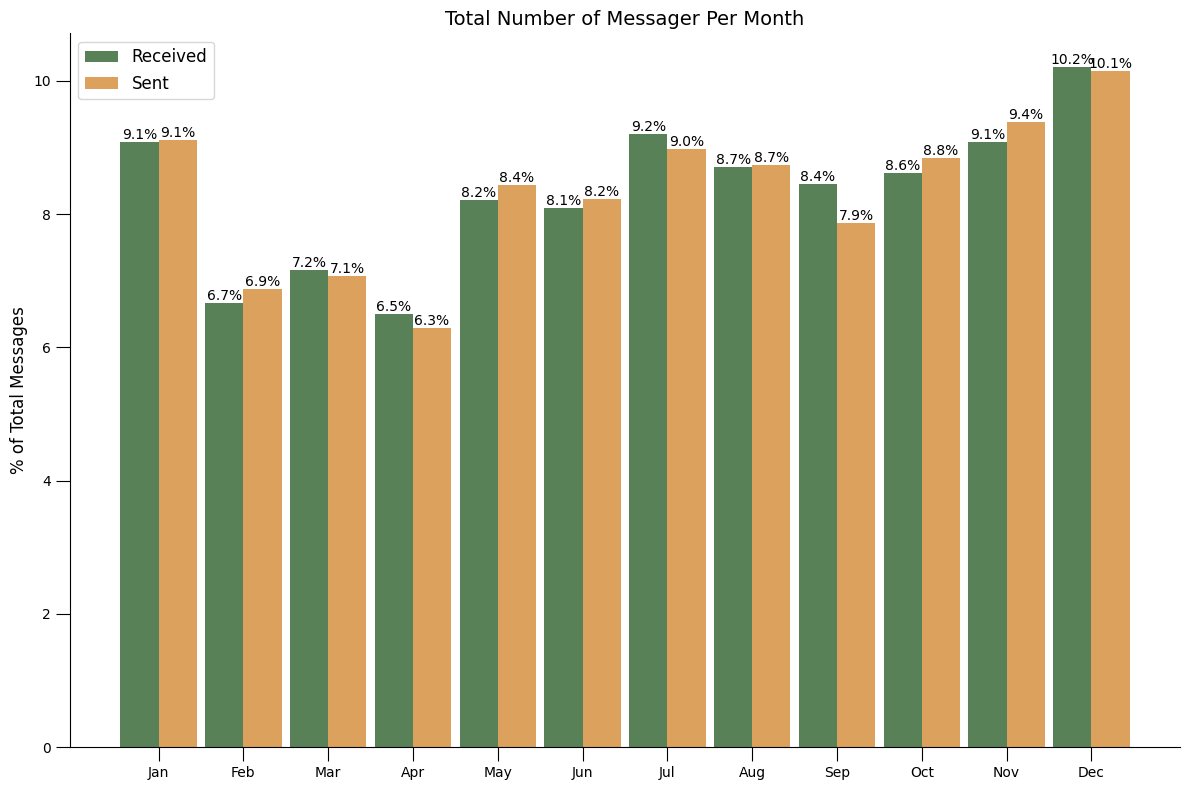

In [33]:
# month of year

plt.figure(figsize=(12, 8))

width = 0.45
bars_received = plt.bar(range(12), per_moy['pct_of_total_received'], color='#588157', width=width ,label='Received')
bars_sent = plt.bar([x+width for x in range(12)], per_moy['pct_of_total_sent'], color='#dda15e' , width=width, label='Sent')


# bars = yearly_counts.plot(kind='bar', color='skyblue', alpha=0)

plt.xticks([x+width/2 for x in range(12)], per_moy['month_of_year'], rotation=0)

plt.xlabel('')

for bar in bars_received.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, str(round(yval, 1))+'%', va='bottom', ha='center')
    
for bar in bars_sent.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, str(round(yval, 1))+'%', va='bottom', ha='center')

    
sns.despine()
# formatter = ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')
# plt.gca().yaxis.set_major_formatter(formatter)
plt.legend(loc='best', fontsize='large')
plt.ylabel("% of Total Messages", fontsize=12)
plt.tick_params(size=10)
plt.title("Total Number of Messager Per Month", fontsize=14)
plt.tight_layout()
